![download.png](download.png)


## Import Packages

In [2]:
#Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import json
import datetime

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## Connect to Snowflake

In [3]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "tasty_data_scientist",
    "warehouse": "tasty_ds_wh",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## Gathering Data as Snowpark DataFrame

In [4]:
#Orders_V
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
#Customer Loyalty
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

## Preview The Data

In [5]:
tasty_bytes_orders_v.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"           |"COUNTRY"  |"FRANCHISE_FLAG"  |"FRANCHISE_ID"  |"FRANCHISEE_FIRST_NAME"  |"FRANCHISEE_LAST_NAME"  |"LOCATION_ID"  |"PLACEKEY"           |"LOCATION_NAME"  |"TOP_CAT

In [6]:
tasty_bytes_customer_loyalty.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66             |Cannon        |Waters       |Toronto    |Canada         |M4C 3M7        |English               |Male         |NULL               |Married           |4                 |2019-10-08 

## Data Exploration

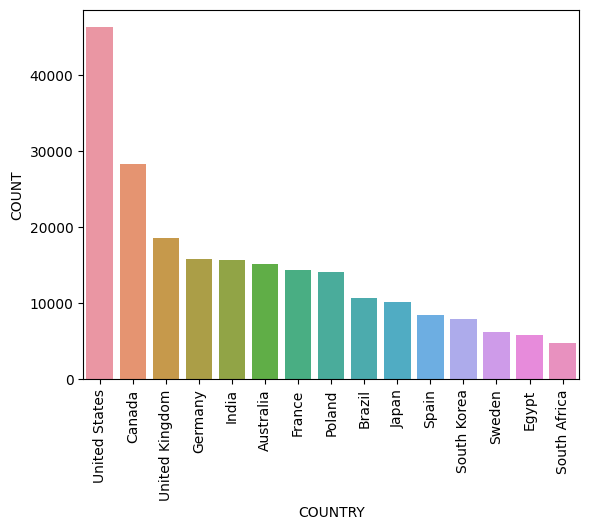

In [13]:
#Unique Customers
temp_df=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.show()

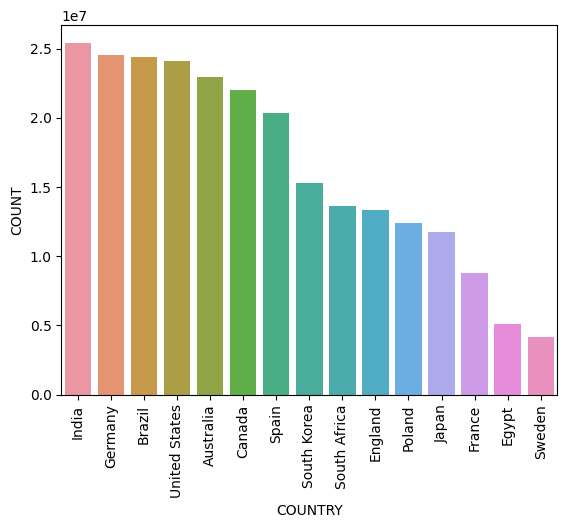

In [19]:
#Number of unique transactions
temp_df=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.show()

In the above code snippets we took a look at the number of unique customers and transactions by cities. We have identified that San Mateo has the highest number of unique customers but the lowest number of transactions which could suggest the highest churn rate.

In [20]:
last_tran_city = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

In [21]:
last_tran_city['CHURN_DATE']=last_tran_city['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_city['CUSTOMER_COUNT_DATE']=last_tran_city['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

In [23]:
last_tran_city_sdf=session.createDataFrame(last_tran_city)
last_tran_city_sdf.show()

---------------------------------------------------------------------------------
|"COUNTRY"    |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |
---------------------------------------------------------------------------------
|Canada       |2022-11-01                |2022-10-18    |2022-09-18             |
|Brazil       |2022-11-01                |2022-10-18    |2022-09-18             |
|Germany      |2022-11-01                |2022-10-18    |2022-09-18             |
|Australia    |2022-11-01                |2022-10-18    |2022-09-18             |
|Japan        |2022-11-01                |2022-10-18    |2022-09-18             |
|Poland       |2022-11-01                |2022-10-18    |2022-09-18             |
|South Korea  |2022-11-01                |2022-10-18    |2022-09-18             |
|Spain        |2022-11-01                |2022-10-18    |2022-09-18             |
|Sweden       |2022-11-01                |2022-10-18    |2022-09-18             |
|England      |2

In [30]:
last_tran_city_sdf_join = last_tran_city_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)

last_tran_city_sdf_join.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"COUNTRY"  |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU

In [31]:
df = last_tran_city_sdf_join[last_tran_city_sdf_join["DATE"] > last_tran_city_sdf_join["CUSTOMER_COUNT_DATE"]]
df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"COUNTRY"  |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"   |"PRI

In [32]:
df2 = df[last_tran_city_sdf_join["DATE"] > last_tran_city_sdf_join["CHURN_DATE"]]

In [33]:
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

cust_bef.show(400)

-------------------------------
|"COUNTRY"      |"COUNT_BEF"  |
-------------------------------
|Canada         |27610        |
|Brazil         |10515        |
|France         |14052        |
|England        |18278        |
|Spain          |8281         |
|Sweden         |6053         |
|Germany        |15337        |
|South Korea    |7756         |
|Australia      |14752        |
|Japan          |9931         |
|Poland         |13734        |
|Egypt          |5556         |
|South Africa   |4670         |
|India          |15419        |
|United States  |44885        |
-------------------------------



In [37]:
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)

calc = calculator.to_pandas()

calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)

temp_df=calc.sort_values(by='CHURN_RATE',ascending=False)

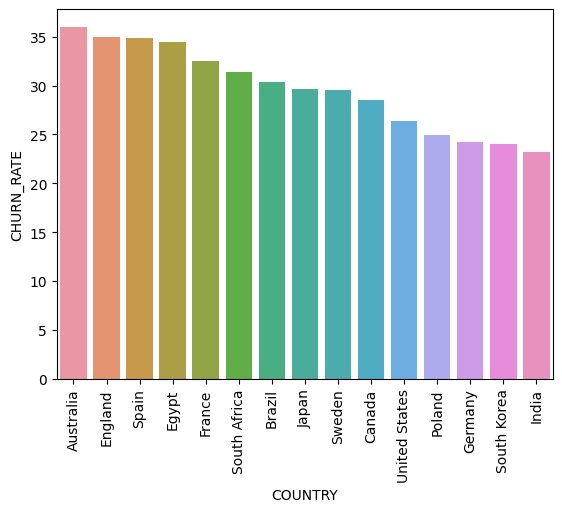

In [38]:
#Churn rate
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=temp_df)
plt.xticks(rotation=90)
plt.show()

Since Australia has quite a number of customers, a huge number of transactions and the highest churn rate. Therefore, we have decided to focus on Australia.

# Table for Modelling

In [54]:
filtered_df=tasty_bytes_orders_v.filter(F.col('COUNTRY')=='Australia')

In [202]:
loyal_customer_orders=tasty_bytes_customer_loyalty.join(
    right=filtered_df,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [210]:
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

In [211]:
loyal_customer_orders.show()
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)
loyal_customer_orders.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [199]:
temp_df=loyal_customer_orders.group_by(F.col('ORDER_ID')).agg(F.sum(F.col('QUANTITY')).alias('Total_Quantity'))
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])
combined_df=remove_dup.join(
    right=temp_df,
    on="ORDER_ID",
    how="inner"
)
combined_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"  |"POSTAL_CODE"  |"PREFER

In [224]:
# assume we have a dataframe called "orders_df" with a column "date"

# Define a window partitioned by customer and ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the next order for each customer
orders_df = combined_df.withColumn("DAYS_TO_NEXT_ORDER", F.lead("DATE").over(window_spec))

# Calculate the number of days between the current order and the next order
orders_df = orders_df.withColumn("DAYS_TO_NEXT_ORDER", F.datediff(col1="DATE", col2="DAYS_TO_NEXT_ORDER",part='day'))

orders_df= orders_df.na.drop(subset=["DAYS_TO_NEXT_ORDER"])

In [227]:
orders_df.show()
print("Number of rows:",orders_df.count())

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"  |"POSTAL_COD

In [ ]:
#Remove unnecessary columns
